In [1]:
import os
import shutil

import numpy as np
import pandas as pd

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

In [2]:
data_directory = 'D:\\OneDrive - UW\\research\\data@aibs' # must be updated to a valid directory in your filesystem

manifest_path = os.path.join(data_directory, "manifest.json")

In [3]:
manifest_path

'D:\\OneDrive - UW\\research\\data@aibs\\manifest.json'

In [4]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [30]:
sessions[sessions.session_type == 'functional_connectivity'].index

766640955

In [5]:
sessions = cache.get_session_table()
#print('Total number of sessions: ' + str(len(sessions)))

#sessions.head()

In [6]:
probes = cache.get_probes()

#print('Total number of probes: ' + str(len(probes)))

#probes.head()

In [7]:

channels = cache.get_channels()

In [8]:

units = cache.get_units()

In [9]:
sessions.ecephys_structure_acronyms.values[44]

array(['PPT', 'MB', 'APN', 'NOT', 'HPF', 'ProS', 'CA1', 'VISam', nan,
       'POL', 'LP', 'DG', 'VISrl', 'ZI', 'IntG', 'IGL', 'CA3', 'VISal',
       'CA2', 'VISl', 'SUB', 'VISp', 'VISpm'], dtype=object)

In [31]:
sessions[sessions.session_type == 'functional_connectivity'].index.size

26

In [33]:
for i in range(sessions[sessions.session_type == 'functional_connectivity'].index[:5].size):
    data=cache.get_session_data(sessions[sessions.session_type == 'functional_connectivity'].index[i])

TimeoutError: 

In [51]:
unit_ids1 = data.units.index.values

In [12]:
class A_Config:
    def __init__(self, data_dir, save_dir, sess_id, stimulus):
        
        self.data_dir = data_dir 
        self.save_dir = save_dir
        self.sess_id = sess_id
        self.stimulus = stimulus

        self.name = "{}/ID{}_{}".format(self.save_dir, self.sess_id, self.stimulus)

In [13]:
save_directory = 'D:\\OneDrive - UW\\research\\data@aibs\\savedir'

In [15]:
allencon = A_Config(data_directory,save_directory,794812542,'drifting_gratings_contrast')

In [10]:
sess_id=794812542
stim_label_list = ['drifting_gratings_contrast']
bin_size=0.01
kernel_width=0.1
#kernel_param=kernel_width/bin_size

In [48]:
import numpy as np
import pandas as pd

data = cache.get_session_data(sess_id)
t_bin = {}
#P = {}
for i, stim_label in enumerate(stim_label_list):
    allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
    print(i)
    # get start, end time points
    stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
    start_time = np.array(stim_data_table.start_time)
    stop_time = np.array(stim_data_table.stop_time)
    trial_time = np.mean(stop_time - start_time)
    bin_edges = np.arange(trial_time + bin_size, step = bin_size )
    t_bin[stim_label] = bin_edges
    print(i)
    stim_presentation_ids = data.stimulus_presentations.loc[
        (data.stimulus_presentations['stimulus_name'] == stim_label)
        ].index.values
    print(i)
    unit_ids = data.units.index.values
    print(i)
    P = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
    pkl.dump(P,open(allencon.name+'_bin_{}_P.p'.format(bin_size),'wb'))
    print(i)
    # get windowed spike times
    # S[i] = window_spk_times(data,start_time,stop_time)
    # get binned spike rates
    # t_bin[i], P[i] = bin_spikes(S[i],bin_size)
    # kernel smoothed estimate of binned spike rates


0
0
0
0
0
Run time for SDF function was 7seconds


In [ ]:

for i, stim_label in enumerate(stim_label_list):
    allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
    P = pkl.load(open(allencon.name+'_bin_{}_P.p'.format(bin_size),'rb'))
    X[stim_label] = smooth_spikes(P.values,kernel_width,bin_size)

In [17]:
X={}

In [50]:
sum(P[stim_label].values)

array([[14,  0,  4, ...,  0,  1,  3],
       [16,  0,  6, ...,  0,  0,  2],
       [16,  2,  2, ...,  0,  1,  0],
       ...,
       [13,  2,  7, ...,  0,  0,  0],
       [13,  0,  7, ...,  0,  0,  0],
       [17,  0,  3, ...,  0,  0,  5]], dtype=uint16)

In [18]:
X[stim_label] = smooth_spikes(P[stim_label].values,kernel_param)

Run time for SDF function was 71seconds


In [22]:
import matplotlib.pyplot as plt

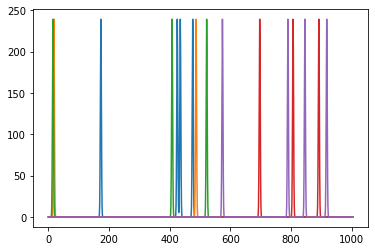

In [29]:
plt.plot(X[stim_label][0,0,:])
plt.plot(X[stim_label][0,1,:])
plt.plot(X[stim_label][0,2,:])
plt.plot(X[stim_label][0,3,:])
plt.plot(X[stim_label][0,4,:])

In [33]:
import numpy as np
import pandas as pd

def load_sess_trials(cache, sess_id, stim_label_list, bin_size, kernel_width):
    # load session data
    data = cache.get_session_data(sess_id)
    t_bin = {}
    P = {}
    X = {}
    for i, stim_label in enumerate(stim_label_list):
        print(i)
        # get start, end time points
        stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
        start_time = np.array(stim_data_table.start_time)
        stop_time = np.array(stim_data_table.stop_time)
        trial_time = np.mean(stop_time - start_time)
        bin_edges = np.arange(trial_time + bin_size, step = bin_size )
        t_bin[stim_label] = bin_edges
        print(i)
        stim_presentation_ids = data.stimulus_presentations.loc[
            (data.stimulus_presentations['stimulus_name'] == stim_label)
            ].index.values
        print(i)
        unit_ids = data.units.index.values
        print(i)
        P[stim_label] = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
        print(i)
        # get windowed spike times
        # S[i] = window_spk_times(data,start_time,stop_time)
        # get binned spike rates
        # t_bin[i], P[i] = bin_spikes(S[i],bin_size)
        # kernel smoothed estimate of binned spike rates
        X[stim_label] = smooth_spikes(P[stim_label].values,kernel_width)
        
    return (t_bin, P, X)

In [17]:
import numpy as np
import pandas as pd
import pickle as pkl

def save_Ps(cache,sess_id,stim_label_list,bin_size):
    data = cache.get_session_data(sess_id)
    #t_bin = {}
    #P = {}
    for i, stim_label in enumerate(stim_label_list):
        allencon = A_Config(data_directory,save_directory,sess_id,stim_label)
        print(i)
        # get start, end time points
        stim_data_table = data.get_stimulus_table()[data.get_stimulus_table().stimulus_name==stim_label]
        start_time = np.array(stim_data_table.start_time)
        stop_time = np.array(stim_data_table.stop_time)
        trial_time = np.mean(stop_time - start_time)
        bin_edges = np.arange(trial_time + bin_size, step = bin_size )
        t_bin = bin_edges
        print(i)
        stim_presentation_ids = data.stimulus_presentations.loc[
            (data.stimulus_presentations['stimulus_name'] == stim_label)
            ].index.values
        print(i)
        unit_ids = data.units.index.values
        print(i)
        P = data.presentationwise_spike_counts(bin_edges,stim_presentation_ids,unit_ids)/bin_size
        pkl.dump(P,open(allencon.name+'_bin_{}_P.p'.format(bin_size),'wb'))
        pkl.dump(t_bin,open(allencon.name+'_bin_{}_t.p'.format(bin_size),'wb'))

In [18]:
save_Ps(cache, 794812542, stim_label_list = ['drifting_gratings_contrast'], bin_size=0.01)

0
0
0
0


In [20]:
def smooth_spikes( P, kernel_width , bin_size ):
    # Rahul
    """
    P: #trials x #units x #time-points sized ndarray
    kernel_param: width of kernel (in samplingrate*1000 units)

    """

    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    trials = P.shape[0]
    units = P.shape[1]
    bins = P.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    kernel_param = kernel_width/bin_size
    sigma = kernel_param/6.
    edges = np.arange(-3*sigma,3*sigma+1,1)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
    kernel = kernel/sum(kernel)
    
    #Compute Spike Density Function for all trials
    #X = np.zeros((trials,units,bins))
    X = sp.signal.convolve(P, kernel[None,None, :], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc
    return X

In [21]:
P=pkl.load(open(allencon.name+'_bin_{}_P.p'.format(bin_size),'rb'))
X = smooth_spikes(P.values,kernel_width=0.1, bin_size= 0.01)

Run time for SDF function was 7seconds


In [23]:
X[0,:,:]

array([[23.95594109, 20.00968398, 11.92673483, ...,  0.        ,
         0.        ,  0.        ],
       [ 4.74084958, 11.66060837, 20.00968398, ..., 20.00968398,
        11.66060837,  4.74084958],
       [ 0.        ,  0.        ,  0.        , ..., 11.66060837,
        20.00968398, 23.95594109],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.74084958, 11.66060837, 20.27581044, ...,  0.        ,
         0.        ,  0.        ]])

In [35]:
t_bin,P,X = load_sess_trials(cache, 794812542, stim_label_list = ['drifting_gratings_contrast'], bin_size=0.01, kernel_param=0.1)

0
0
0
0
0


TypeError: 1st argument must be a real sequence 2

In [45]:
dir()

['EcephysProjectCache',
 'In',
 'Out',
 'P',
 'X',
 '_',
 '_11',
 '_12',
 '_13',
 '_19',
 '_20',
 '_23',
 '_24',
 '_25',
 '_26',
 '_27',
 '_28',
 '_29',
 '_3',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_42',
 '_9',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29',
 '_i3',
 '_i30',
 '_i31',
 '_i32',
 '_i33',
 '_i34',
 '_i35',
 '_i36',
 '_i37',
 '_i38',
 '_i39',
 '_i4',
 '_i40',
 '_i41',
 '_i42',
 '_i43',
 '_i44',
 '_i45',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'bin_edges',
 'bin_size',
 'cache',
 'channels',
 'data',
 'data_directory',
 'edges',
 'exit',
 'get_ipython',
 'i',
 'kernel',
 'kernel_param',
 'kernel_width',
 'manifest_path',
 'np',
 'os',
 'pd',
 'plt',
 'probes',
 '

In [45]:
data_dg=data.get_stimulus_table()[data.get_stimulus_table().stimulus_name=='drifting_gratings_contrast']

In [46]:
data_dg

,Dir,Speed,coherence,color,contrast,frame,orientation,phase,pos,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,
3798,null,null,null,null,0.35,null,135,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1630.286968,2,drifting_gratings_contrast,1630.787380,2,null,null,0.500412,246
3799,null,null,null,null,1,null,0,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1631.287792,2,drifting_gratings_contrast,1631.788205,2,null,null,0.500413,247
3800,null,null,null,null,0.08,null,135,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1632.288618,2,drifting_gratings_contrast,1632.789040,2,null,null,0.500422,248
3801,null,null,null,null,0.04,null,0,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1633.289462,2,drifting_gratings_contrast,1633.789880,2,null,null,0.500418,249
3802,null,null,null,null,0.6,null,135,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,1634.290298,2,drifting_gratings_contrast,1634.790720,2,null,null,0.500422,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4333,null,null,null,null,0.01,null,135,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,2165.734552,2,drifting_gratings_contrast,2166.234970,2,null,null,0.500418,251
4334,null,null,null,null,0.01,null,0,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,2166.735388,2,drifting_gratings_contrast,2167.235805,2,null,null,0.500417,271
4335,null,null,null,null,0.2,null,45,"[4198.96666667, 4198.96666667]","[0.0, 0.0]","[250.0, 250.0]",0.04,2167.736222,2,drifting_gratings_contrast,2168.236645,2,null,null,0.500423,267


In [35]:
data.spike_times

{951083985: array([5.33825146e+00, 5.47181830e+00, 5.50218500e+00, ...,
        9.81591354e+03, 9.81593267e+03, 9.81594284e+03]),
 951083957: array([4.79551743e+00, 7.39140732e+01, 7.51185081e+01, ...,
        9.51460011e+03, 9.51461245e+03, 9.68948841e+03]),
 951083886: array([  84.09111969,   84.09565302,   84.1038197 , ..., 9775.45375085,
        9781.65739218, 9781.74455896]),
 951083884: array([4.84975083e+00, 2.23217067e+01, 2.34154414e+01, ...,
        9.81594710e+03, 9.81611114e+03, 9.81615180e+03]),
 951083843: array([3.91554963e+00, 3.92201630e+00, 4.73335068e+00, ...,
        9.81461800e+03, 9.81542170e+03, 9.81592940e+03]),
 951083838: array([5.32098477e+00, 5.58978512e+00, 3.35467878e+01, ...,
        9.81167313e+03, 9.81477883e+03, 9.81480043e+03]),
 951083821: array([  68.26979928,   98.13207113,   98.47117156, ..., 9806.10225704,
        9815.42906907, 9815.83733626]),
 951083801: array([4.89488422e+00, 5.07081778e+00, 6.26531932e+00, ...,
        9.81488490e+03, 9.8153

In [39]:
data.units.index

Int64Index([951082755, 951082761, 951082759, 951082764, 951082786, 951082795,
            951082791, 951082798, 951082828, 951082838,
            ...
            951105734, 951106350, 951106341, 951106335, 951105779, 951106447,
            951105767, 951106361, 951105795, 951105928],
           dtype='int64', name='unit_id', length=1005)

In [40]:
data.spike_times[data.units.index[0]]

array([3.69361601e+00, 3.87444957e+00, 3.90548295e+00, ...,
       9.81352760e+03, 9.81353403e+03, 9.81598637e+03])

In [49]:
unit_spikes=data.spike_times[data.units.index[0]]

In [60]:
unit_spikes[np.logical_and(unit_spikes>=data_dg.start_time.values[0],unit_spikes<data_dg.start_time.values[1])]

array([1630.29488031, 1630.58018068, 1630.6447141 , 1630.67111413,
       1630.68534748, 1630.6990475 , 1630.71088085, 1630.7281142 ,
       1630.7481809 ])

In [47]:
def smooth_spikes( P, kernel_width , bin_size ):
    # Rahul
    """
    P: #trials x #units x #time-points sized ndarray
    kernel_param: width of kernel (in samplingrate*1000 units)

    """

    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    trials = P.shape[0]
    units = P.shape[1]
    bins = P.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    kernel_param = kernel_width/bin_size
    sigma = kernel_param/6.
    edges = np.arange(-3*sigma,3*sigma+1,1)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
    kernel = kernel/sum(kernel)
    
    #Compute Spike Density Function for all trials
    #X = np.zeros((trials,units,bins))
    X = sp.signal.convolve(P, kernel[None,None, :], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc
    return X

In [33]:
import scipy as sp

In [34]:
kernel_width = 0.01
sigma = kernel_width/6.
edges = np.arange(-3*sigma,3*sigma+.001,.001)
kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function

In [41]:
kernel_width = .01
bin_size = .001
kernel_param = kernel_width/bin_size
sigma = kernel_param/6.
edges = np.arange(-3*sigma,3*sigma+1,1)
kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function
kernel = kernel/sum(kernel)

1.0000000000000002


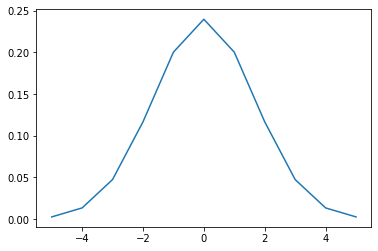

In [43]:
plt.plot(edges,kernel/sum(kernel))
print(sum(kernel))

In [38]:
sum(kernel)

999.1900021000848

In [45]:
def est_frate(P_stim, k_p):
    """
    P_stim: #trials x #units x #time-points sized ndarray
    k_p: width of kernel (in samplingrate*1000 units)

    """

    import numpy as np
    import time
    import scipy.stats, scipy.signal
    import scipy as sp

    start = time.time() # tic Measures function running speed. Works only on Macs

    trials = P_stim.shape[0]
    units = P_stim.shape[1]
    bins = P_stim.shape[2]

    # Create fake data for testing purposes
    #    array = np.random.randint(0,2,(trials,bins))
    #    sigma = 45

    #Define kernel
    sigma = k_p/6. 
    edges = np.arange(-3*sigma,3*sigma+.001,.001)
    kernel = sp.stats.norm.pdf(edges,0, sigma) #Use a gaussian function

    #Compute Spike Density Function for all trials
    Sdf = np.zeros((trials,units,bins))
    Sdf = sp.signal.convolve(P_stim, kernel[None,None, :], mode='same',method='direct')

    print('Run time for SDF function was ' + str(round(time.time()-start)) + 'seconds') # toc

    return Sdf

In [24]:
P_stim = np.random.rand(3,5,100)

In [25]:
P_stim

array([[[0.0207709 , 0.61439839, 0.88211257, ..., 0.31775952,
         0.30567903, 0.27399221],
        [0.37336281, 0.18674841, 0.41940279, ..., 0.32011922,
         0.66396872, 0.34112103],
        [0.03582578, 0.16321012, 0.37431344, ..., 0.41234224,
         0.21534986, 0.81560207],
        [0.23898016, 0.35467651, 0.40979947, ..., 0.2637528 ,
         0.97756855, 0.01196253],
        [0.69437601, 0.00948424, 0.78666093, ..., 0.16578161,
         0.20964782, 0.566196  ]],

       [[0.93546489, 0.27312036, 0.02946449, ..., 0.54969334,
         0.05257927, 0.57582248],
        [0.91656141, 0.69573916, 0.2265184 , ..., 0.86667568,
         0.27791852, 0.60212333],
        [0.6388305 , 0.38493382, 0.9699952 , ..., 0.12950176,
         0.28399591, 0.68553295],
        [0.89167243, 0.22846354, 0.7171408 , ..., 0.91295058,
         0.78296388, 0.82778095],
        [0.84969995, 0.81780512, 0.74067701, ..., 0.89276604,
         0.55408111, 0.89525658]],

       [[0.48408948, 0.57640775, 0.3

In [35]:
X_stim=est_frate(P_stim,0.01)

Run time for SDF function was 0seconds


In [36]:
X_stim

array([[[255.57579604, 407.29374668, 523.13998834, ..., 266.15602175,
         226.60787231, 173.3469688 ],
        [220.44063813, 322.52476068, 412.97157362, ..., 390.62212242,
         353.77866374, 273.24111694],
        [104.79023116, 173.92118098, 228.74846968, ..., 528.50987738,
         437.55567812, 335.95112217],
        [196.74990928, 283.52396118, 366.93851318, ..., 401.44861039,
         345.0626075 , 245.94394729],
        [298.67715926, 403.10062448, 479.73828512, ..., 369.20186183,
         308.69246857, 238.45584935]],

       [[313.8535134 , 340.24277052, 322.33448764, ..., 395.32564049,
         319.48458793, 239.63041078],
        [402.53498868, 451.39344934, 437.98849388, ..., 597.29645337,
         488.67569117, 346.41628979],
        [360.62847752, 465.67608703, 501.3710228 , ..., 343.31595964,
         313.22439249, 264.49981254],
        [376.7641974 , 476.08666472, 539.58461174, ..., 754.05813227,
         673.02964695, 511.1333202 ],
        [473.24378963, 575

In [28]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [29]:
import matplotlib.pyplot as plt

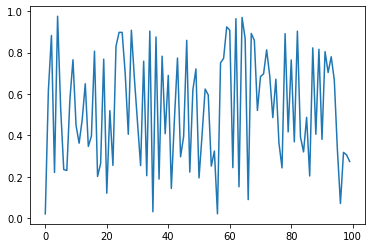

In [30]:
plt.plot(P_stim[0,0,:])


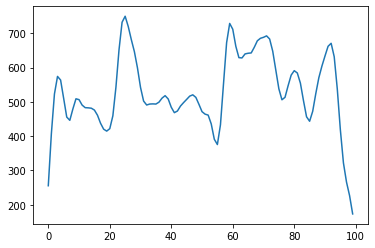

In [31]:
plt.plot(X_stim[0,0,:])

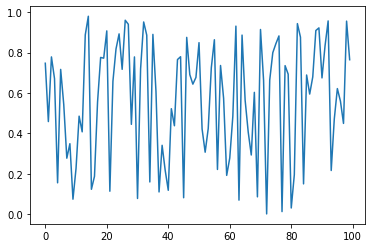

In [25]:
plt.plot(P_stim[0,1,:])

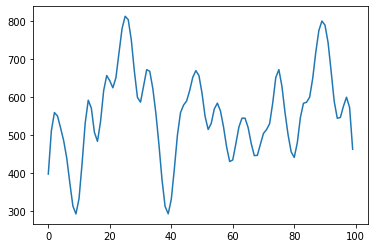

In [26]:
plt.plot(X_stim[0,1,:])

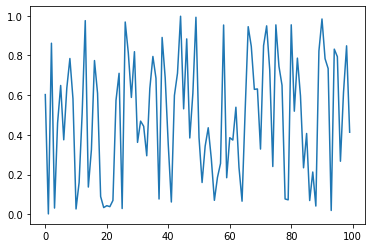

In [27]:
plt.plot(P_stim[1,1,:])

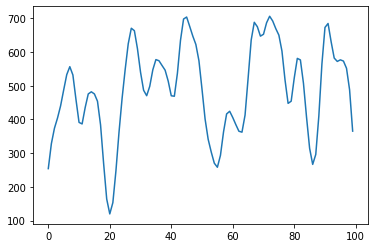

In [28]:
plt.plot(X_stim[1,1,:])